In [9]:
import sys
import os
from dotenv import load_dotenv
from IPython.display import Image, display
from enum import Enum
from operator import add
from typing import TypedDict, Annotated, List, Dict, Any, Optional
from langchain_openai import ChatOpenAI
from langchain_core.tools import Tool
from langchain_core.messages import HumanMessage, SystemMessage, AIMessage
from langgraph.graph import add_messages, StateGraph, START, END
from langgraph.prebuilt import ToolNode
from langgraph.checkpoint.memory import MemorySaver
from langchain_community.utilities import GoogleSerperAPIWrapper

load_dotenv(override=True)

True

In [10]:

llm = ChatOpenAI(model="gpt-4o-mini")
serper = GoogleSerperAPIWrapper()
tool_web_search = Tool(
    name="web_search",
    func=serper.run,
    description="Useful for when you need more information from the web about a query"
)
tools = [tool_web_search]
llm_with_tools = llm.bind_tools(tools)


In [13]:
class Phase(str, Enum):
    GENERATE = "generate"
    VALIDATE = "validate"
    AUDIT = "audit"
    COMPLETE = "complete"

# Structured output schemas for task decomposition
from pydantic import BaseModel, Field
from typing import List

class DomainTask(BaseModel):
    """Schema for individual domain tasks"""
    domain: str = Field(description="The domain name (compute, network, storage, database)")
    task_description: str = Field(description="Clear description of the task for this domain")
    requirements: List[str] = Field(description="Key requirements and constraints for this domain")
    aws_services: List[str] = Field(description="Specific AWS services to consider for this domain")
    deliverables: List[str] = Field(description="Expected deliverables for this domain")

class TaskDecomposition(BaseModel):
    """Schema for the complete task decomposition"""
    user_problem: str = Field(description="The original user problem")
    decomposed_tasks: List[DomainTask] = Field(description="List of domain-specific tasks")
    overall_architecture_goals: List[str] = Field(description="High-level architecture goals")
    constraints: List[str] = Field(description="Global constraints that apply to all domains")
    estimated_complexity: str = Field(description="Overall complexity assessment (low, medium, high)")

In [12]:

def merge_dicts(left: Dict[str, Any], right: Dict[str, Any]) -> Dict[str, Any]:
    """Merge two dictionaries, with right taking precedence over left."""
    result = left.copy()
    result.update(right)
    return result

def last_value(left: Any, right: Any) -> Any:
    """Keep the last value (right takes precedence)."""
    return right

class State(TypedDict):
    messages: Annotated[List, add_messages]
    user_problem: Annotated[str, last_value]
    current_phase: Annotated[Phase, last_value]
    iteration_count: Annotated[int, last_value]
    
    architecture_domain_tasks: Annotated[Dict[str, Dict[str, Any]], merge_dicts]

    proposed_architecture: Annotated[Dict[str, Any], merge_dicts]
    architecture_components: Annotated[Dict[str, Dict[str, Any]], merge_dicts]

    validation_feedback: Annotated[List[Dict[str, Any]], add]
    audit_feedback: Annotated[List[Dict[str, Any]], add]

    # active_agents: Annotated[List[str], add]
    # completed_agents: Annotated[List[str], add]

    factual_errors_exist: Annotated[bool, last_value]
    design_flaws_exist: Annotated[bool, last_value]

    final_architecture: Annotated[Optional[Dict[str, Any]], last_value]
    architecture_summary: Annotated[Optional[str], last_value]

In [18]:
def architect_supervisor(state: State) -> State:
    """
    This function orchestrates the architecture generation process using structured output for task decomposition.
    """

    system_prompt = f"""
    You are an architect supervisor for AWS cloud architecture.
    Your role is to decompose the user's problem into structured domain-specific tasks and assign them to different architect domain agents.

    User Problem: {state["user_problem"]}
    Current Iteration: {state["iteration_count"]}

    Available feedback:
    - Validation feedback: {state["validation_feedback"]}
    - Audit feedback: {state["audit_feedback"]}

    Proposed Architecture: {state["proposed_architecture"]}
    Architecture Components: {state["architecture_components"]}

    Decompose the problem into structured tasks for these domains:
    1. Compute Architect (EC2, Lambda, ECS, EKS, Auto Scaling, etc.)
    2. Network Architect (VPC, Subnets, ALB, CloudFront, Route 53, Security Groups, etc.)
    3. Storage Architect (S3, EBS, EFS, etc.)
    4. Database Architect (RDS, DynamoDB, ElastiCache, etc.)

    For each domain, provide:
    - Clear task description
    - Key requirements and constraints
    - Specific AWS services to consider
    - Expected deliverables

    Also provide overall architecture goals and global constraints.
    """

    # Create LLM with structured output
    structured_llm = llm.with_structured_output(TaskDecomposition)
    
    messages = [SystemMessage(content=system_prompt)]
    response = structured_llm.invoke(messages)

    # Store the structured decomposition in state
    new_state = state.copy()
    new_state["messages"].append(AIMessage(content=f"Task decomposition completed: {response.user_problem}"))
    
    # Store the structured decomposition for use by domain agents
    new_state["architecture_domain_tasks"] = {
        "decomposition": response.dict(),
        "overall_goals": response.overall_architecture_goals,
        "constraints": response.constraints,
        "complexity": response.estimated_complexity
    }
    
    # Extract domain tasks for each agent
    for task in response.decomposed_tasks:
        new_state["architecture_domain_tasks"][task.domain] = {
            "task_description": task.task_description,
            "requirements": task.requirements,
            # "aws_services": task.aws_services,
            "deliverables": task.deliverables
        }
    
    # new_state["active_agents"] = ["compute_architect", "network_architect", "storage_architect", "database_architect"]
    # new_state["completed_agents"] = []

    return new_state

In [10]:
memory = MemorySaver()

In [16]:
def create_initial_state(user_problem: str) -> State:
    """
    Create the initial state for the architecture generation process.
    """
    return {
        "messages": [HumanMessage(content=user_problem)],
        "user_problem": user_problem,
        "current_phase": Phase.GENERATE,
        "iteration_count": 0,
        "architecture_domain_tasks": {},
        "proposed_architecture": {},
        "architecture_components": {},
        "validation_feedback": [],
        "audit_feedback": [],
        # "active_agents": [],
        # "completed_agents": [], 
        "factual_errors_exist": False,
        "design_flaws_exist": False,
        "final_architecture": None,
        "architecture_summary": None
    }

In [17]:
# def mark_agent_complete(state: State, agent_name: str) -> State:
#     """
#     Mark the specified agent as complete in the state.
#     """
#     new_state = state.copy()
#     # For Annotated types, we return the new value to be added
#     new_state["completed_agents"] = [agent_name]
#     return new_state

In [ ]:
def compute_architect(state: State) -> State:
    """
    This function implements the AWS compute domain architect agent using structured task information.
    """

    # Get structured task information for compute domain
    compute_task = state["architecture_domain_tasks"].get("compute", {})
    overall_goals = state["architecture_domain_tasks"].get("overall_goals", [])
    constraints = state["architecture_domain_tasks"].get("constraints", [])
    
    system_prompt = f"""
    You are a compute domain architect for AWS cloud architecture.
    Your role is to design the compute infrastructure based on the structured task decomposition.

    Original Problem: {state["user_problem"]}
    
    Your Specific Task:
    - Description: {compute_task.get('task_description', 'Design compute infrastructure')}
    - Requirements: {compute_task.get('requirements', [])}
    # - AWS Services to Consider: {compute_task.get('aws_services', ['EC2', 'Lambda', 'ECS', 'EKS'])}
    - Expected Deliverables: {compute_task.get('deliverables', [])}
    - Priority Level: {compute_task.get('priority', 3)}
    
    Overall Architecture Goals: {overall_goals}
    Global Constraints: {constraints}

    Design compute components considering:
    - EC2 instances (types, sizes, placement groups)
    - Lambda functions (serverless compute)
    - ECS/EKS (container orchestration)
    - Auto Scaling Groups
    - Load Balancers
    - Compute optimization strategies, etc.

    Use the web search only if you need more information about compute pricing, features, or best practices.
    Provide detailed configuration recommendations based on the structured requirements.
    Focus on the compute domain and DO NOT include any other domain in your response.
    """

    messages = [SystemMessage(content=system_prompt)]
    response = llm_with_tools.invoke(messages)

    # new_state = mark_agent_complete(state, "compute_architect")
    new_state = state.copy()
    new_state["messages"].append(AIMessage(content=response.content))
    
    # Store structured component information
    new_state["architecture_components"] = {
        "compute": {
            "recommendations": response.content,
            "agent": "compute_architect",
            "task_info": compute_task
            # "priority": compute_task.get('priority', 3)
        }
    }

    return new_state

In [ ]:
def network_architect(state: State) -> State:
    """AWS network domain architect using structured task information."""
    
    # Get structured task information for network domain
    network_task = state["architecture_domain_tasks"].get("network", {})
    overall_goals = state["architecture_domain_tasks"].get("overall_goals", [])
    constraints = state["architecture_domain_tasks"].get("constraints", [])
    
    system_prompt = f"""
    You are an AWS Network Domain Architect.
    Your role is to design the network infrastructure based on the structured task decomposition.

    Original Problem: {state['user_problem']}
    
    Your Specific Task:
    - Description: {network_task.get('task_description', 'Design network infrastructure')}
    - Requirements: {network_task.get('requirements', [])}
    # - AWS Services to Consider: {network_task.get('aws_services', ['VPC', 'ALB', 'CloudFront', 'Route53'])}
    - Expected Deliverables: {network_task.get('deliverables', [])}
    # - Priority Level: {network_task.get('priority', 3)}
    
    Overall Architecture Goals: {overall_goals}
    Global Constraints: {constraints}
    
    Design network infrastructure considering:
    - VPC design and subnets
    - Security Groups and NACLs
    - Load Balancers (ALB, NLB, CLB)
    - CloudFront/CDN
    - Route 53 DNS
    - VPN/Direct Connect
    - Network security and compliance, etc.
    
    Use the web search only if you need more information about network pricing, features, or best practices.
    Provide detailed network architecture based on the structured requirements.
    Focus on the network domain and DO NOT include any other domain in your response.
    """
    
    messages = [SystemMessage(content=system_prompt)]
    response = llm_with_tools.invoke(messages)
    
    # new_state = mark_agent_complete(state, "network_architect")
    new_state = state.copy()
    new_state["messages"].append(AIMessage(content=response.content))
    
    # Store structured component information
    new_state["architecture_components"] = {
        "network": {
            "recommendations": response.content,
            "agent": "network_architect",
            "task_info": network_task,
            # "priority": network_task.get('priority', 3)
        }
    }
    
    return new_state

In [23]:
def storage_architect(state: State) -> State:
    """AWS storage domain architect using structured task information."""
    
    # Get structured task information for storage domain
    storage_task = state["architecture_domain_tasks"].get("storage", {})
    overall_goals = state["architecture_domain_tasks"].get("overall_goals", [])
    constraints = state["architecture_domain_tasks"].get("constraints", [])
    
    system_prompt = f"""
    You are an AWS Storage Domain Architect.
    Your role is to design the storage infrastructure based on the structured task decomposition.

    Original Problem: {state['user_problem']}
    
    Your Specific Task:
    - Description: {storage_task.get('task_description', 'Design storage infrastructure')}
    - Requirements: {storage_task.get('requirements', [])}
    # - AWS Services to Consider: {storage_task.get('aws_services', ['S3', 'EBS', 'EFS'])}
    - Expected Deliverables: {storage_task.get('deliverables', [])}
    # - Priority Level: {storage_task.get('priority', 3)}
    
    Overall Architecture Goals: {overall_goals}
    Global Constraints: {constraints}

    Design storage infrastructure considering:
    - S3 buckets (storage classes, lifecycle policies)
    - EBS volumes (types, performance characteristics)
    - EFS file systems (shared storage)
    - Data backup and recovery strategies
    - Storage security and encryption
    - Cost optimization for storage, etc.

    Use the web search only if you need more information about storage pricing, features, or best practices.
    Provide detailed storage architecture based on the structured requirements.
    Focus on the storage domain and DO NOT include any other domain in your response.
    """

    messages = [SystemMessage(content=system_prompt)]
    response = llm_with_tools.invoke(messages)

    # new_state = mark_agent_complete(state, "storage_architect")
    new_state = state.copy()
    new_state["messages"].append(AIMessage(content=response.content))
    
    # Store structured component information
    new_state["architecture_components"] = {
        "storage": {
            "recommendations": response.content,
            "agent": "storage_architect",
            "task_info": storage_task,
            # "priority": storage_task.get('priority', 3)
        }
    }   

    return new_state


In [24]:
def database_architect(state: State) -> State:
    """AWS database domain architect using structured task information."""
    
    # Get structured task information for database domain
    database_task = state["architecture_domain_tasks"].get("database", {})
    overall_goals = state["architecture_domain_tasks"].get("overall_goals", [])
    constraints = state["architecture_domain_tasks"].get("constraints", [])
    
    system_prompt = f"""
    You are an AWS Database Domain Architect.
    Your role is to design the database infrastructure based on the structured task decomposition.

    Original Problem: {state['user_problem']}
    
    Your Specific Task:
    - Description: {database_task.get('task_description', 'Design database infrastructure')}
    - Requirements: {database_task.get('requirements', [])}
    # - AWS Services to Consider: {database_task.get('aws_services', ['RDS', 'DynamoDB', 'ElastiCache'])}
    - Expected Deliverables: {database_task.get('deliverables', [])}
    # - Priority Level: {database_task.get('priority', 3)}
    
    Overall Architecture Goals: {overall_goals}
    Global Constraints: {constraints}

    Design database infrastructure considering:
    - RDS (relational databases, multi-AZ, read replicas)
    - DynamoDB (NoSQL, global tables, DAX)
    - ElastiCache (Redis, Memcached)
    - Database security and encryption
    - Backup and disaster recovery
    - Performance optimization and scaling, etc.

    Use the web search only if you need more information about database pricing, features, or best practices.
    Provide detailed database architecture based on the structured requirements.
    Focus on the database domain and DO NOT include any other domain in your response.
    """         

    messages = [SystemMessage(content=system_prompt)]
    response = llm_with_tools.invoke(messages)

    # new_state = mark_agent_complete(state, "database_architect")
    new_state = state.copy()
    new_state["messages"].append(AIMessage(content=response.content))
    
    # Store structured component information
    new_state["architecture_components"] = {
        "database": {
            "recommendations": response.content,
            "agent": "database_architect",
            "task_info": database_task,
            # "priority": database_task.get('priority', 3)
        }
    }

    return new_state


In [18]:
def phase_router(state: State) -> State:
    """
    This function implements the phase routing based on the current_phase and quality gates.
    """
    if state["current_phase"] == Phase.GENERATE:
        return "architect_supervisor"
    elif state["current_phase"] == Phase.VALIDATE:
        return "validator_supervisor"
    elif state["current_phase"] == Phase.AUDIT:
        return "auditor_supervisor"
    elif state["current_phase"] == Phase.COMPLETE:
        return "final_presenter"
    else:
        return "architect_supervisor"

In [ ]:
def architect_coordinator(state: State) -> State:
    """
    Coordinates the completion of all architect agents. 
    """
    new_state = state.copy()
    new_state["messages"].append({
        "role": "system",
        "content": "All architect agents have completed their tasks. Moving to validation phase."
    })

    return new_state

In [ ]:
def architect_synthesizer(state: State) -> State:
    """
    Synthesizes the architecture components provided by the architect agents into a final architecture.
    """
    system_prompt = f"""
    You are an AWS architect synthesizer.
    You are given the architecture components provided by the architect agents.
    Synthesize the architecture components into a final architecture.
    """
    messages = [SystemMessage(content=system_prompt)]
    response = llm.invoke(messages)

    new_state = state.copy()
    new_state["messages"].append(AIMessage(content=response.content))
    new_state["proposed_architecture"] = response.content
    return state

SyntaxError: incomplete input (26276711.py, line 5)

In [20]:
graph_builder = StateGraph(State)

graph_builder.add_node("architect_supervisor", architect_supervisor)
graph_builder.add_node("compute_architect", compute_architect)
graph_builder.add_node("network_architect", network_architect)
graph_builder.add_node("storage_architect", storage_architect)
graph_builder.add_node("database_architect", database_architect)
graph_builder.add_node("architect_coordinator", architect_coordinator)

# Parallel execution with Annotated types to handle multiple values
graph_builder.add_edge(START, "architect_supervisor")
graph_builder.add_edge("architect_supervisor", "compute_architect")
graph_builder.add_edge("architect_supervisor", "network_architect")
graph_builder.add_edge("architect_supervisor", "storage_architect")
graph_builder.add_edge("architect_supervisor", "database_architect")

graph_builder.add_edge("compute_architect", "architect_coordinator")
graph_builder.add_edge("network_architect", "architect_coordinator")
graph_builder.add_edge("storage_architect", "architect_coordinator")
graph_builder.add_edge("database_architect", "architect_coordinator")

# graph = graph_builder.compile(checkpointer=memory)
graph = graph_builder.compile()

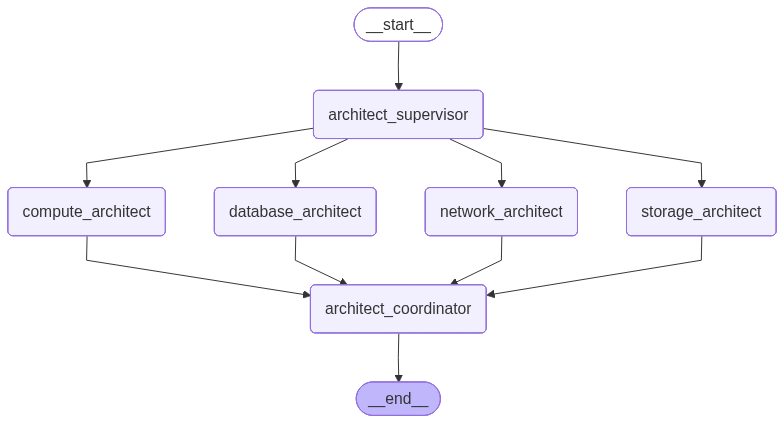

In [21]:
graph

In [22]:
def validator_supervisor(state: State) -> State:
    """
    This function implements the validator supervisor for the architecture generation process.
    """

    system_prompt = f"""
    You are a validator supervisor for the AWS cloud architecture.
    Your role is to supervise the domain validation of the architecture components for factual correctness.

    Architecture to validate: {state["architecture_components"]}

    Based on the user's problem, decompse the architecture into domain components and assign them to different domain validator agents respectively.

    For each domain, provide the proposed components and their respective AWS services.

    Format your response as a structured breakdown for each domain.
    """

    messages = [SystemMessage(content=system_prompt)]
    response = llm.invoke(messages)

    new_state = state.copy()
    new_state["messages"].append(AIMessage(content=response.content))

    new_state["active_agents"] = ["compute_validator", "network_validator", "storage_validator", "database_validator"]
    new_state["completed_agents"] = []

    return new_state


In [23]:
tool_RAG_search = Tool(
    name="RAG_search",
    func=serper.run, # Add RAG search tool
    description="Useful for when you need more information from the web about a query"
)


In [24]:
llm_with_RAG = llm.bind_tools([tool_RAG_search])

In [25]:
def compute_validator(state: State) -> State:
    """
    This function implements the compute domain validator against the cloud documentation for the architecture generation process.
    """

    system_prompt = f"""
    You are a compute domain validator for the AWS cloud architecture. 
    Use the documentation to validate the compute components.

    Use the RAG tools to search for:
    - Service compatibility 
    - Configuration specifications
    - Service limitations
    - Technical requirements

    Report any factual errors or inconsistencies in the architecture components.
    """

    messages = [SystemMessage(content=system_prompt)]
    response = llm_with_RAG.invoke(messages)

    new_state = state.copy()
    new_state["messages"].append(AIMessage(content=response.content))

    return new_state

In [26]:
def network_validator(state: State) -> State:
    """
    This function implements the network domain validator against the cloud documentation for the architecture generation process.
    """

    system_prompt = f"""
    You are a network domain validator for the AWS cloud architecture.
    Use the documentation to validate the network components.

    Use the RAG tools to search for:
    - Service compatibility 
    - Configuration specifications
    - Service limitations
    - Technical requirements

    Report any factual errors or inconsistencies in the architecture components.
    """

    messages = [SystemMessage(content=system_prompt)]
    response = llm_with_RAG.invoke(messages)

    new_state = state.copy()
    new_state["messages"].append(AIMessage(content=response.content))

    return new_state

In [27]:
def storage_validator(state: State) -> State:
    """
    This function implements the storage domain validator against the cloud documentation for the architecture generation process.
    """

    system_prompt = f"""
    You are a storage domain validator for the AWS cloud architecture.
    Use the documentation to validate the storage components.

    Use the RAG tools to search for:
    - Service compatibility 
    - Configuration specifications
    - Service limitations
    - Technical requirements

    Report any factual errors or inconsistencies in the architecture components.
    """

    messages = [SystemMessage(content=system_prompt)]
    response = llm_with_RAG.invoke(messages)

    new_state = state.copy()
    new_state["messages"].append(AIMessage(content=response.content))

    return new_state

In [28]:
def database_validator(state: State) -> State:
    """
    This function implements the database domain validator against the cloud documentation for the architecture generation process.
    """

    system_prompt = f"""
    You are a database domain validator for the AWS cloud architecture.
    Use the documentation to validate the database components.

    Use the RAG tools to search for:
    - Service compatibility 
    - Configuration specifications
    - Service limitations
    - Technical requirements

    Report any factual errors or inconsistencies in the architecture components.
    """

    messages = [SystemMessage(content=system_prompt)]
    response = llm_with_RAG.invoke(messages)

    new_state = state.copy()
    new_state["messages"].append(AIMessage(content=response.content))

    return new_state

In [29]:
def validator_reducer(state: State) -> State:
    """
    This function combines the validation results from the different domain validators.
    """

    system_prompt = f"""
    You are a validator reducer for the AWS cloud architecture.
    Combine the validation results from the different domain validators and provide a summary of the validation results.
    And respond True if there are no factual errors or inconsistencies in the architecture components, otherwise respond False.
    """

    messages = [SystemMessage(content=system_prompt)]
    response = llm.invoke(messages)

    new_state = state.copy()
    new_state["messages"].append(AIMessage(content=response.content))
    new_state["validation_feedback"] = response.content
    new_state["factual_errors_exist"] = False if response.content == "True" else True
    return new_state


In [30]:
def inner_loop_router(state: State) -> str:
    """
    Inner loop: Routes back to architects if factual errors exist.
    Routes to audit phase if no factual errors.
    """
    if state["factual_errors_exist"]:
        # Reset for new iteration
        new_state = state.copy()
        new_state["current_phase"] = Phase.GENERATE
        new_state["iteration_count"] += 1
        return "architect_supervisor"
    else:
        return "END"

In [39]:
tool_web_search_node = ToolNode(tools=[tool_web_search])

In [44]:
def web_search_tool_condition(state: State) -> bool:
    last_message = state["messages"][-1]
    
    if hasattr(last_message, "tool_calls") and last_message.tool_calls:
        return "tools"
    else:
        return "coordinator"

In [59]:
tool_RAG_node = ToolNode(tools=[tool_RAG_search])

In [60]:
def RAG_search_tool_condition(state: State) -> bool:
    last_message = state["messages"][-1]
    
    if hasattr(last_message, "tool_calls") and last_message.tool_calls:
        return "tools"
    else:
        return "coordinator"

In [61]:
graph_builder = StateGraph(State)

graph_builder.add_node("architect_supervisor", architect_supervisor)
graph_builder.add_node("compute_architect", compute_architect)
graph_builder.add_node("network_architect", network_architect)
graph_builder.add_node("storage_architect", storage_architect)
graph_builder.add_node("database_architect", database_architect)
graph_builder.add_node("architect_coordinator", architect_coordinator)

# Parallel execution with Annotated types to handle multiple values
graph_builder.add_edge(START, "architect_supervisor")
graph_builder.add_edge("architect_supervisor", "compute_architect")
graph_builder.add_edge("architect_supervisor", "network_architect")
graph_builder.add_edge("architect_supervisor", "storage_architect")
graph_builder.add_edge("architect_supervisor", "database_architect")

graph_builder.add_node("web_search", tool_web_search_node)
graph_builder.add_conditional_edges("compute_architect", web_search_tool_condition, {"tools": "web_search", "coordinator": "architect_coordinator"})
graph_builder.add_conditional_edges("network_architect", web_search_tool_condition, {"tools": "web_search", "coordinator": "architect_coordinator"})
graph_builder.add_conditional_edges("storage_architect", web_search_tool_condition, {"tools": "web_search", "coordinator": "architect_coordinator"})
graph_builder.add_conditional_edges("database_architect", web_search_tool_condition, {"tools": "web_search", "coordinator": "architect_coordinator"})

graph_builder.add_edge("web_search", "compute_architect")
graph_builder.add_edge("web_search", "network_architect")
graph_builder.add_edge("web_search", "storage_architect")
graph_builder.add_edge("web_search", "database_architect")

graph_builder.add_edge("compute_architect", "architect_coordinator")
graph_builder.add_edge("network_architect", "architect_coordinator")
graph_builder.add_edge("storage_architect", "architect_coordinator")
graph_builder.add_edge("database_architect", "architect_coordinator")

graph_builder.add_node("validator_supervisor", validator_supervisor)
graph_builder.add_node("compute_validator", compute_validator)
graph_builder.add_node("network_validator", network_validator)
graph_builder.add_node("storage_validator", storage_validator)
graph_builder.add_node("database_validator", database_validator)
graph_builder.add_node("validator_reducer", validator_reducer)
graph_builder.add_node("RAG", tool_RAG_node)

graph_builder.add_conditional_edges("compute_validator", RAG_search_tool_condition, {"tools": "RAG", "coordinator": "validator_reducer"})
graph_builder.add_conditional_edges("network_validator", RAG_search_tool_condition, {"tools": "RAG", "coordinator": "validator_reducer"})
graph_builder.add_conditional_edges("storage_validator", RAG_search_tool_condition, {"tools": "RAG", "coordinator": "validator_reducer"})
graph_builder.add_conditional_edges("database_validator", RAG_search_tool_condition, {"tools": "RAG", "coordinator": "validator_reducer"})

graph_builder.add_edge("RAG", "compute_validator")
graph_builder.add_edge("RAG", "network_validator")
graph_builder.add_edge("RAG", "storage_validator")
graph_builder.add_edge("RAG", "database_validator")

graph_builder.add_edge("architect_coordinator", "validator_supervisor")
graph_builder.add_edge("validator_supervisor", "compute_validator")
graph_builder.add_edge("validator_supervisor", "network_validator")
graph_builder.add_edge("validator_supervisor", "storage_validator")
graph_builder.add_edge("validator_supervisor", "database_validator")

graph_builder.add_edge("compute_validator", "validator_reducer")
graph_builder.add_edge("network_validator", "validator_reducer")
graph_builder.add_edge("storage_validator", "validator_reducer")
graph_builder.add_edge("database_validator", "validator_reducer")

graph_builder.add_conditional_edges(
    "validator_reducer",
    inner_loop_router,
    {
        True: "architect_supervisor",
        False: END
    }
)

graph = graph_builder.compile()

In [64]:
graph.get_graph()

Graph(nodes={'__start__': Node(id='__start__', name='__start__', data=RunnableCallable(tags=None, recurse=True, explode_args=False, func_accepts={}), metadata=None), 'architect_supervisor': Node(id='architect_supervisor', name='architect_supervisor', data=architect_supervisor(tags=None, recurse=True, explode_args=False, func_accepts={}), metadata=None), 'compute_architect': Node(id='compute_architect', name='compute_architect', data=compute_architect(tags=None, recurse=True, explode_args=False, func_accepts={}), metadata=None), 'network_architect': Node(id='network_architect', name='network_architect', data=network_architect(tags=None, recurse=True, explode_args=False, func_accepts={}), metadata=None), 'storage_architect': Node(id='storage_architect', name='storage_architect', data=storage_architect(tags=None, recurse=True, explode_args=False, func_accepts={}), metadata=None), 'database_architect': Node(id='database_architect', name='database_architect', data=database_architect(tags=No

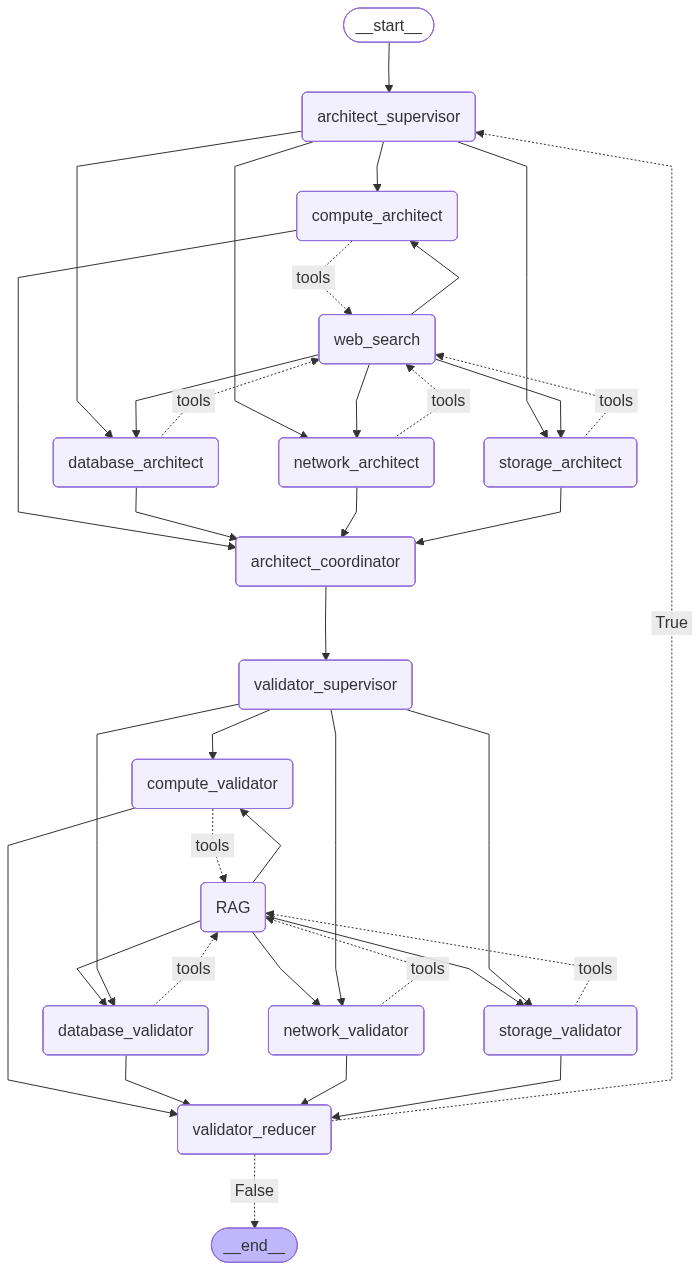

In [62]:
display(Image(graph.get_graph().draw_mermaid_png()))

In [ ]:
# Test the new structured output implementation
def test_structured_decomposition():
    """
    Test function to demonstrate the new structured output task decomposition.
    """
    # Create a test user problem
    test_problem = """
    I need to design a scalable e-commerce platform on AWS that can handle:
    - 100,000 concurrent users
    - High availability (99.9% uptime)
    - Global content delivery
    - Secure payment processing
    - Real-time inventory management
    - Cost optimization
    """
    
    print("Testing Structured Output Task Decomposition")
    print("=" * 50)
    print(f"User Problem: {test_problem}")
    print("\nCreating initial state...")
    
    # Create initial state
    initial_state = create_initial_state(test_problem)
    
    print("Running architect_supervisor with structured output...")
    
    # Run the architect supervisor to get structured decomposition
    result_state = architect_supervisor(initial_state)
    
    print("\nStructured Task Decomposition Results:")
    print("=" * 40)
    
    # Display the structured decomposition
    if "architecture_domain_tasks" in result_state:
        tasks = result_state["architecture_domain_tasks"]
        
        print(f"Overall Goals: {tasks.get('overall_goals', [])}")
        print(f"Global Constraints: {tasks.get('constraints', [])}")
        print(f"Complexity Assessment: {tasks.get('complexity', 'Unknown')}")
        
        print("\nDomain-Specific Tasks:")
        print("-" * 30)
        
        for domain in ["compute", "network", "storage", "database"]:
            if domain in tasks:
                task = tasks[domain]
                print(f"\n{domain.upper()} DOMAIN:")
                print(f"  Description: {task.get('task_description', 'N/A')}")
                print(f"  Requirements: {task.get('requirements', [])}")
                print(f"  AWS Services: {task.get('aws_services', [])}")
                print(f"  Deliverables: {task.get('deliverables', [])}")
                print(f"  Priority: {task.get('priority', 'N/A')}")
    
    return result_state

# Run the test
test_result = test_structured_decomposition()


In [ ]:
# Example: How domain experts use structured task information
def demonstrate_domain_expert_usage():
    """
    Demonstrate how domain experts now use structured task information
    instead of just the raw user query.
    """
    print("\n" + "="*60)
    print("DOMAIN EXPERT USAGE WITH STRUCTURED OUTPUT")
    print("="*60)
    
    # Simulate running a domain expert with structured information
    print("\n1. COMPUTE ARCHITECT EXAMPLE:")
    print("-" * 30)
    
    # Show what the compute architect now receives
    sample_compute_task = {
        "task_description": "Design scalable compute infrastructure for e-commerce platform",
        "requirements": [
            "Handle 100,000 concurrent users",
            "Auto-scaling capabilities", 
            "High availability",
            "Cost optimization"
        ],
        "aws_services": ["EC2", "Lambda", "ECS", "Auto Scaling Groups"],
        "deliverables": [
            "Compute architecture diagram",
            "Instance type recommendations",
            "Scaling policies",
            "Cost estimates"
        ],
        "priority": 5
    }
    
    print("Structured Task Information:")
    for key, value in sample_compute_task.items():
        print(f"  {key}: {value}")
    
    print("\n2. BENEFITS OF STRUCTURED OUTPUT:")
    print("-" * 30)
    benefits = [
        "✅ Consistent task format across all domains",
        "✅ Clear requirements and deliverables for each domain",
        "✅ Priority-based task ordering",
        "✅ Structured AWS service recommendations",
        "✅ Better coordination between domain experts",
        "✅ Improved traceability and accountability"
    ]
    
    for benefit in benefits:
        print(f"  {benefit}")
    
    print("\n3. COMPARISON: Before vs After")
    print("-" * 30)
    print("BEFORE (Raw User Query):")
    print("  - Domain experts received: 'Design a scalable e-commerce platform'")
    print("  - Each expert had to interpret requirements independently")
    print("  - Inconsistent task understanding across domains")
    print("  - No clear prioritization or coordination")
    
    print("\nAFTER (Structured Output):")
    print("  - Domain experts receive: Specific, structured task information")
    print("  - Clear requirements, deliverables, and priorities")
    print("  - Consistent understanding across all domains")
    print("  - Better coordination and task alignment")
    
    return True

# Run the demonstration
demonstrate_domain_expert_usage()


# Structured Output Implementation Summary

## What Was Implemented

### 1. **Pydantic Schemas for Task Decomposition**
- `DomainTask`: Individual domain task schema with requirements, AWS services, deliverables, and priority
- `TaskDecomposition`: Complete task decomposition schema with overall goals and constraints

### 2. **Enhanced Architect Supervisor**
- Uses `llm.with_structured_output(TaskDecomposition)` for consistent task decomposition
- Stores structured task information in state for domain experts to use
- Provides clear task descriptions, requirements, and priorities for each domain

### 3. **Updated Domain Expert Agents**
- **Compute Architect**: Now receives structured compute-specific tasks
- **Network Architect**: Gets structured network infrastructure requirements  
- **Storage Architect**: Receives structured storage design specifications
- **Database Architect**: Gets structured database architecture requirements

## Key Benefits

### ✅ **Consistent Task Format**
- All domain experts receive tasks in the same structured format
- Clear requirements, deliverables, and priorities for each domain

### ✅ **Better Coordination**
- Domain experts work with aligned understanding of overall goals
- Global constraints are shared across all domains
- Priority-based task ordering ensures critical components are addressed first

### ✅ **Improved Traceability**
- Each domain task includes specific requirements and expected deliverables
- Clear AWS service recommendations for each domain
- Better accountability and task completion tracking

### ✅ **Enhanced Quality**
- Structured output ensures consistent task decomposition
- Domain experts have clear, specific requirements instead of interpreting raw user queries
- Better alignment between user requirements and domain-specific implementations

## Usage Example

```python
# The architect_supervisor now uses structured output:
structured_llm = llm.with_structured_output(TaskDecomposition)
response = structured_llm.invoke(messages)

# Domain experts receive structured task information:
compute_task = state["architecture_domain_tasks"].get("compute", {})
# Contains: task_description, requirements, aws_services, deliverables, priority
```

This implementation transforms the system from using raw user queries to using structured, domain-specific task decompositions that provide clear guidance to each domain expert.
